In [1]:
import re
import json

In [51]:
with open('Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 20178

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
257     1365119        20178              208   
258     1257620        20178              208   
414     2991445        20178              369   
415     2991437        20178              369   
416     2991375        20178              369   

                                                 title  year  \
257  Physical Carrier Sense in Vehicular Ad-Hoc Net...  2011   
258     Area-Based Dissemination in Vehicular Networks  2014   
414  Transmission Mode Selection and Resource Alloc...  2016   
415  Enhancing Improved Heuristic Drift Elimination...  2016   
416  Optimal Approach to Provide Electric Vehicles ...  2016   

                                              abstract  
257  Enhancing road safety using vehicle-to-vehicle...  
258  Pure opportunistic dissemination of content in...  
414  In this paper, we propose solutions to the tra...  
415  Location based services are limited due to the...  
416  Mobile charging stations (MCSs) can provide el...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

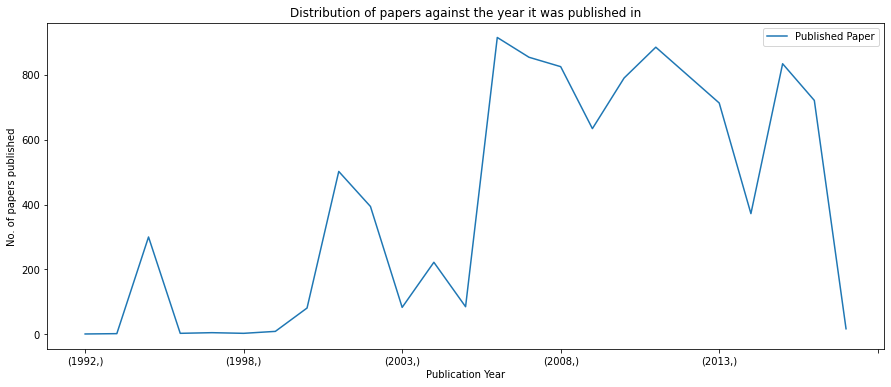

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2004 with year 2006 accounting for the highest number of papers followed by 2011.

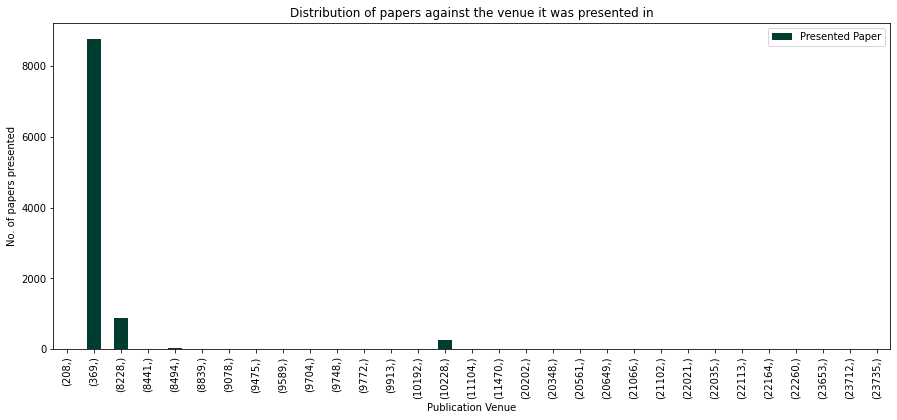

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [15]:
conference_data_dict[369]

'vehicular technology conference'

One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 369 which corresponds to the **Vehicular Technology Conference**, Hence most of the papers in the community are from that conference. We should be expecting papers about vehicles and technological proposals related to vehicles from the papers of this community.

In [16]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

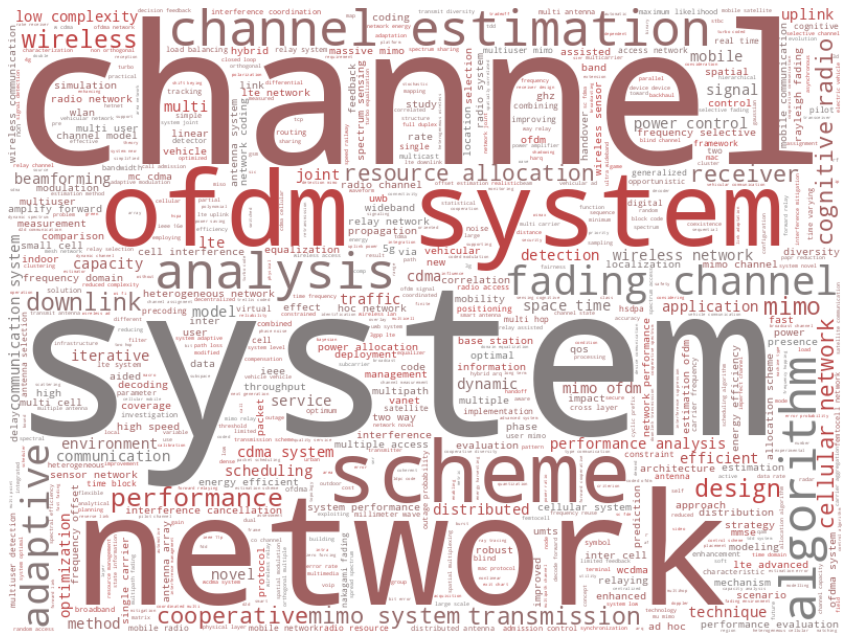

In [17]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

From the wordcloud, we see the most frequently used words or terms from the titles of the papers. The words channel, system, network are dominant in most of the paper titles. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

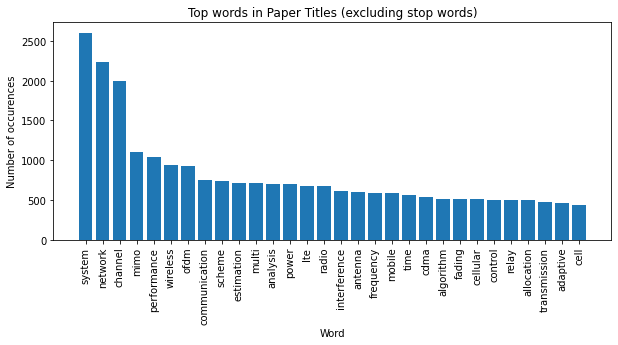

In [18]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are system, network, channel and so on. Considering most papers are about vehicular technology, the results make sense.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [19]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [20]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [21]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [22]:
lda.show_topics(total_topics,6)

[(0,
  '0.061*"network" + 0.039*"multi" + 0.027*"system" + 0.026*"coverage" + 0.024*"user" + 0.020*"cell"'),
 (1,
  '0.031*"power" + 0.028*"speed" + 0.027*"high" + 0.023*"resource" + 0.020*"efficient" + 0.019*"joint"'),
 (2,
  '0.034*"channel" + 0.032*"performance" + 0.031*"radio" + 0.029*"fading" + 0.021*"system" + 0.019*"evaluation"'),
 (3,
  '0.032*"network" + 0.029*"frequency" + 0.026*"sign" + 0.025*"system" + 0.024*"cellular" + 0.023*"approach"'),
 (4,
  '0.043*"channel" + 0.033*"relay" + 0.029*"performance" + 0.020*"two" + 0.019*"mimo" + 0.018*"way"'),
 (5,
  '0.048*"communication" + 0.044*"vehicle" + 0.027*"mobile" + 0.027*"system" + 0.024*"femtocells" + 0.023*"wave"'),
 (6,
  '0.075*"network" + 0.031*"wireless" + 0.024*"mobile" + 0.023*"service" + 0.021*"heterogeneous" + 0.020*"scenario"'),
 (7,
  '0.027*"system" + 0.025*"network" + 0.023*"approximation" + 0.023*"ofdm" + 0.022*"channel" + 0.022*"log"'),
 (8,
  '0.043*"time" + 0.032*"system" + 0.032*"video" + 0.028*"channel" + 0

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [23]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

network     multi    system  coverage      user      cell  wireless  \
0  0.061268  0.038648  0.026781  0.026368  0.024283  0.020055  0.019848   
1  0.016851  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.020616  0.000000  0.000000  0.000000  0.000000   
3  0.031768  0.000000  0.024796  0.000000  0.000000  0.000000  0.012275   
4  0.010984  0.000000  0.017457  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.027139  0.000000  0.000000  0.000000  0.000000   
6  0.074863  0.000000  0.012735  0.000000  0.000000  0.013495  0.030785   
7  0.025247  0.000000  0.026535  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.031755  0.000000  0.000000  0.000000  0.016516   
9  0.007858  0.008016  0.052689  0.000000  0.000000  0.000000  0.000000   

         bi     route       lte  ...  diagonal   complex  transmission  \
0  0.018492  0.017995  0.017681  ...  0.000000  0.000000      0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000      0.000000   
2  0.000000  0.000000  0.000000  ...  0.000000  0.000000      0.000000   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000      0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000      0.000000   
5  0.000000  0.000000  0.009195  ...  0.000000  0.000000      0.000000   
6  0.000000  0.000000  0.014160  ...  0.000000  0.000000      0.000000   
7  0.000000  0.000000  0.000000  ...  0.000000  0.000000      0.000000   
8  0.000000  0.000000  0.023340  ...  0.010359  0.010273      0.000000   
9  0.000000  0.000000  0.009373  ...  0.000000  0.000000      0.021666   

     uplink  independent  multiuser  beamforming  technique     ofdma  \
0  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
1  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
2  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
3  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
4  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
5  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
6  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
7  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
8  0.000000     0.000000   0.000000     0.000000   0.000000  0.000000   
9  0.013809     0.011915   0.010868     0.009555   0.009233  0.008201   

     cyclic  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.000000  
6  0.000000  
7  0.000000  
8  0.000000  
9  0.007824  

[10 rows x 184 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


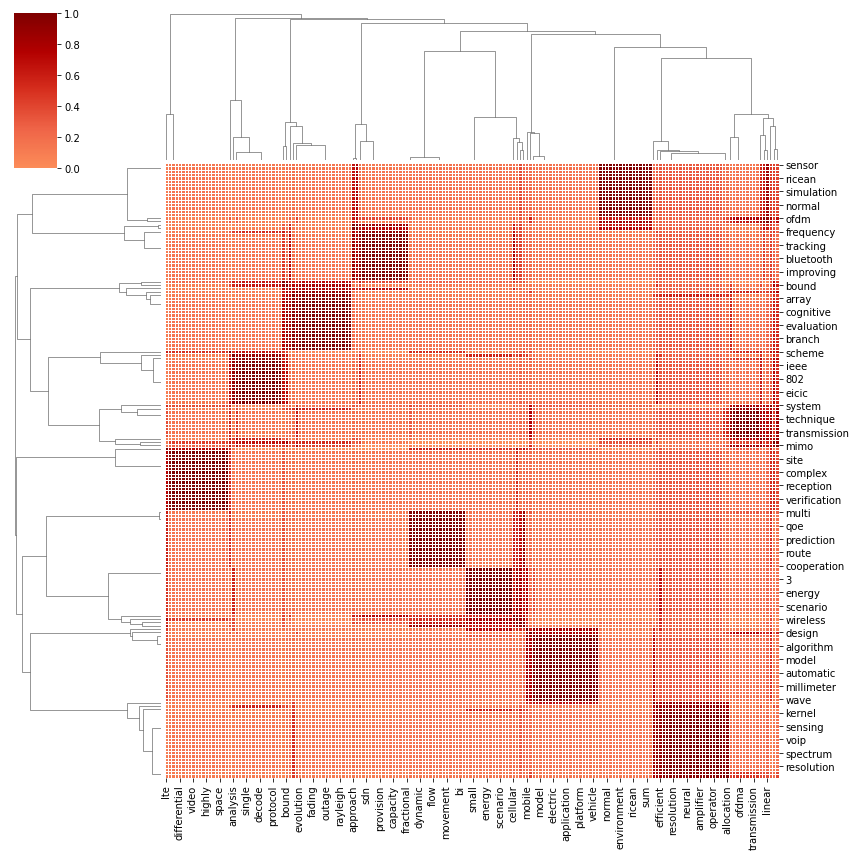

In [24]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [25]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  24.043148
1       0.648955  71.707100       2        1  19.325156
4      71.019684   9.971006       3        1  14.266803
5       3.785981  33.185135       4        1   8.968148
6     -42.666500  -9.222070       5        1   7.469070
0      -3.621689 -43.526516       6        1   5.714043
9      -3.632402  -4.171708       7        1   5.060490
8     -36.584400  35.804413       8        1   5.051959
7      44.391380  50.615383       9        1   5.051735
2      40.235809 -31.591665      10        1   5.049449, topic_info=          Term        Freq       Total Category  logprob  loglift
3      network  242.000000  242.000000  Default  30.0000  30.0000
24      system  217.000000  217.000000  Default  29.0000  29.0000
110    channel  174.000000  174.000000  Default  28.0000  28.0000
36     vehicle   51.000000   51.000000  Default  27.0000  27.0000
154       ofdm   74.000000   74.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
77    spectrum    3.799093   44.100948  Topic10  -4.8946   0.5342
81    analysis    3.957402   67.112039  Topic10  -4.8537   0.1551
3      network    4.418082  242.644393  Topic10  -4.7436  -1.0200
135  frequency    3.864437  105.024690  Topic10  -4.8775  -0.3165
31      mobile    3.264887   68.417364  Topic10  -5.0461  -0.0565

[602 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2616      3  1.058301        's
894       3  0.878205        11
1722      2  0.820194       11a
666       3  0.761190       11p
1899      3  0.897011       16e
...     ...       ...       ...
150      10  0.011560  wireless
1978      5  0.986900   wishart
647       7  1.073740   without
1999     10  1.167266      wpan
434      10  0.568566      zero

[1162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 6, 7, 1, 10, 9, 8, 3])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [26]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [27]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [28]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  m2m, transfer, authentication, mmwave, heuristic, feasibility, world, signature, minimax, forecast, word, leasing, preliminary, quantize, inference

Paper Titles:
Dynamic specrum leasing for beamforming cogniive radio neworks using nework coding
Feasibility of Rainbow Signature for Broadcast Authentication in Sensor Networks
Verifying 3G License Requirements - Some Preliminary Swedish Results
Seat Occupancy and Belt Detection in Removable Seats via Inductive Coupling

****************************************************************************************************
TOPIC 1:
Top Words:  maximum, likelihood, zero, optical, noise, region, vehicle, condition, v2v, free, forcing, electric, fi, band, trial

Paper Titles:
Complex Baseband Myriad Filtering and Maximum Likelihood MSK Demodulation under Symmetric Alpha-Stable Noise
A Wideband One-Ring MIMO Channel Model Under Non-Isotropic Scattering Conditions
Vehicle positioning by database comparison using the Box-Cox m

## Analyzing the abstracts of the papers

In [29]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

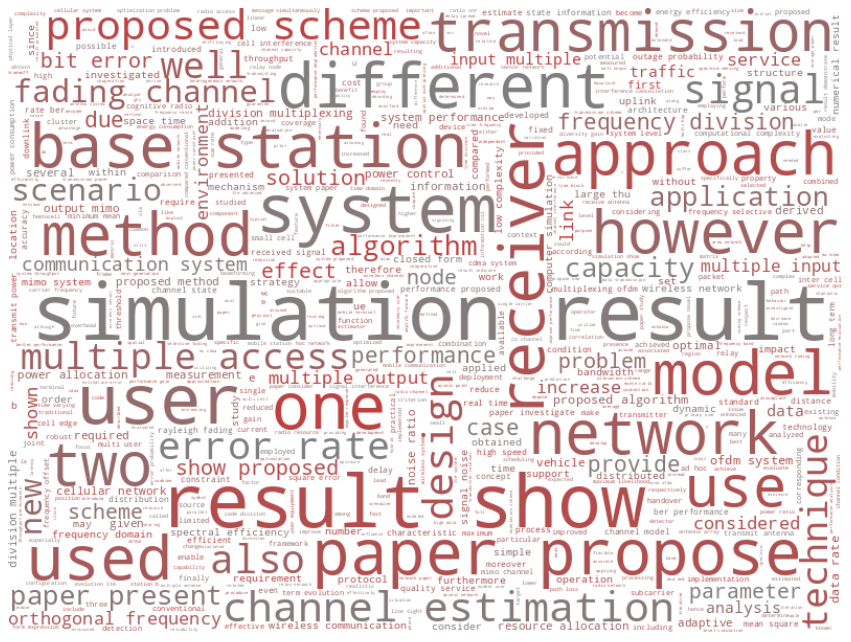

In [30]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [31]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [32]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [33]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [34]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [35]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [36]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [37]:
lda.show_topics(total_topics, 7)

[(0,
  '0.018*"channel" + 0.016*"performance" + 0.012*"method" + 0.011*"scheme" + 0.009*"system" + 0.009*"channel estimation" + 0.009*"proposed"'),
 (1,
  '0.015*"system" + 0.013*"scheme" + 0.011*"performance" + 0.010*"algorithm" + 0.010*"handoff call" + 0.009*"proposed" + 0.007*"mimo"'),
 (2,
  '0.028*"traffic sign" + 0.018*"rank adaptation" + 0.012*"mobility" + 0.011*"network" + 0.011*"coverage hole" + 0.010*"vehicle" + 0.010*"movement"'),
 (3,
  '0.019*"network" + 0.011*"service" + 0.010*"small cell" + 0.009*"cell" + 0.007*"user" + 0.007*"scheme" + 0.006*"algorithm"'),
 (4,
  '0.013*"system" + 0.007*"channel" + 0.007*"proposed" + 0.007*"scheme" + 0.005*"method" + 0.005*"mobility environment" + 0.005*"performance"'),
 (5,
  '0.010*"algorithm" + 0.010*"user" + 0.010*"proposed" + 0.009*"scheme" + 0.008*"channel" + 0.006*"video" + 0.006*"rate"'),
 (6,
  '0.028*"relay" + 0.020*"protocol" + 0.016*"channel" + 0.014*"performance" + 0.010*"system" + 0.008*"scheme" + 0.008*"multiple"'),
 (7,


In [38]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

channel  performance    method    scheme    system  channel estimation  \
0  0.018437     0.015964  0.011972  0.010939  0.009384            0.009011   
1  0.006552     0.010813  0.000000  0.012931  0.015028            0.000000   
2  0.000000     0.005120  0.000000  0.005737  0.000000            0.000000   
3  0.000000     0.000000  0.000000  0.006917  0.000000            0.000000   
4  0.006854     0.005059  0.005427  0.006686  0.013494            0.000000   
5  0.007518     0.005902  0.003232  0.008764  0.006211            0.000000   
6  0.016084     0.014345  0.000000  0.007973  0.010323            0.000000   
7  0.006493     0.008099  0.000000  0.004944  0.009300            0.000000   
8  0.006452     0.010546  0.006144  0.005154  0.016026            0.000000   
9  0.000000     0.007195  0.005019  0.005760  0.011974            0.000000   

   proposed  accuracy      show      case  ...  beamforming       ber  \
0  0.008798  0.005847  0.005674  0.004999  ...     0.000000  0.000000   
1  0.008712  0.000000  0.003876  0.000000  ...     0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  ...     0.000000  0.000000   
3  0.000000  0.000000  0.003555  0.000000  ...     0.000000  0.000000   
4  0.006810  0.000000  0.003413  0.000000  ...     0.000000  0.000000   
5  0.009792  0.000000  0.004235  0.000000  ...     0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.005530  ...     0.000000  0.000000   
7  0.003403  0.000000  0.005357  0.000000  ...     0.000000  0.000000   
8  0.005515  0.000000  0.005568  0.000000  ...     0.005938  0.004473   
9  0.004912  0.000000  0.004513  0.000000  ...     0.000000  0.000000   

        bep     ofdm  downlink  throughput  efficiency  approach  \
0  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
1  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
2  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
3  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
4  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
5  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
6  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
7  0.000000  0.00000  0.000000    0.000000    0.000000  0.000000   
8  0.003907  0.00358  0.003461    0.000000    0.000000  0.000000   
9  0.000000  0.00000  0.000000    0.005689    0.004487  0.003892   

   base station       e g  
0      0.000000  0.000000  
1      0.000000  0.000000  
2      0.000000  0.000000  
3      0.000000  0.000000  
4      0.000000  0.000000  
5      0.000000  0.000000  
6      0.000000  0.000000  
7      0.000000  0.000000  
8      0.000000  0.000000  
9      0.003329  0.003316  

[10 rows x 142 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



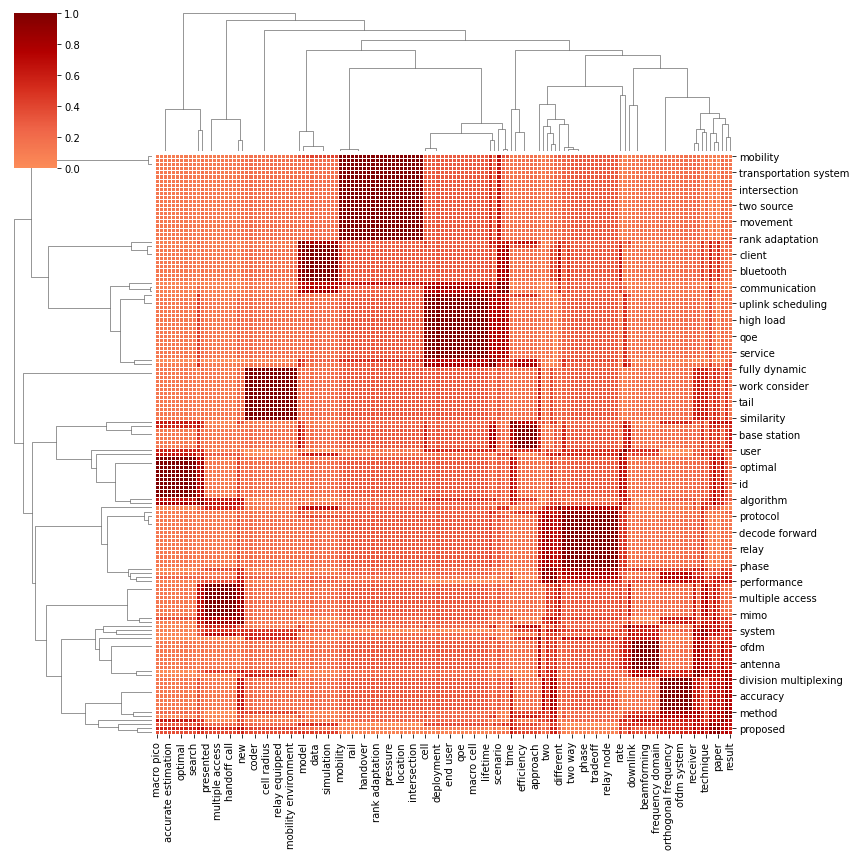

In [39]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [40]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  28.350085
3       0.648955  71.707100       2        1  16.355529
7      71.019684   9.971006       3        1  10.871124
0       3.785981  33.185135       4        1   9.429857
1     -42.666500  -9.222070       5        1   6.900184
8      -3.621689 -43.526516       6        1   6.139240
5      -3.632402  -4.171708       7        1   5.659365
6     -36.584400  35.804413       8        1   5.433237
4      44.391380  50.615383       9        1   5.431380
2      40.235809 -31.591665      10        1   5.430001, topic_info=               Term       Freq      Total Category  logprob  loglift
14209  traffic sign  15.000000  15.000000  Default  30.0000  30.0000
1755          relay  16.000000  16.000000  Default  29.0000  29.0000
837         channel  58.000000  58.000000  Default  28.0000  28.0000
308        protocol  27.000000  27.000000  Default  27.0000  27.0000
138          system  95.000000  95.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
130          scheme   3.130499  71.803359  Topic10  -5.1608  -0.2195
68      performance   2.793613  79.691908  Topic10  -5.2746  -0.4376
533        scenario   2.080967  24.797966  Topic10  -5.5691   0.4353
181        location   1.973419  13.358814  Topic10  -5.6222   1.0008
192            real   1.932326  10.285648  Topic10  -5.6432   1.2412

[698 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
20717      1  0.751014            100 m
19400      5  1.278945            2 sup
22418      4  1.350137           300 km
19169      2  0.864955       3g network
22784      5  1.084629    3gpp standard
...      ...       ...              ...
16096      3  0.710867  wireless medium
18919      4  1.157125   wishart matrix
3071       6  1.076394         within 0
10023      9  1.276512    work consider
24927      6  1.260183   yet considered

[1073 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 8, 1, 2, 9, 6, 7, 5, 3])

In [42]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [43]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [44]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  nb iot, rgba led, rgba, filling problem, dense stadium, beam searching, hybrid ray, hybrid ray tracing, coding across multiple, multiple frequency layer, coding across, frequency layer, across multiple frequency, ambient backscatter, ebit

Paper Titles:
Green Cellular Demand Control with User-in-the-Loop Enabled by Smart Data Pricing Using an Effective Quantum (eBit) Tariff
Synthesis of Radiation Patterns in Arbitrary Geometry Antenna Arrays
R-OFDM Transmission Scheme for Visible Light Communication Using RGBA-LED
A Study on Channel Modeling in Tunnel Scenario Based on Propagation-Graph Theory

****************************************************************************************************
TOPIC 1:
Top Words:  sr scheme, urban structure, detecting congestion, lead predict congestion, lead predict, predict congestion, congestion propagation, predict congestion propagation, geographical context, congestion estimation, ran mme, ota setup proposed, reconstruction a

In [48]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [50]:
representative_df.to_csv("repr_20178.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
514      3052207        20178              369   
789      2847777        20178              369   
526      3007663        20178              369   
765      2875774        20178              369   
607      3107243        20178              369   
...          ...          ...              ...   
434      3002145        20178              369   
487      3020701        20178              369   
8258      930098        20178              369   
6535     1547938        20178              369   
4088     2087648        20178              369   

                                                  title  year  \
514   Green Cellular Demand Control with User-in-the...  2016   
789   Synthesis of Radiation Patterns in Arbitrary G...  2016   
526   R-OFDM Transmission Scheme for Visible Light C...  2016   
765   A Study on Channel Modeling in Tunnel Scenario...  2016   
607   Indoor Channel Measurements Using a 28GHz mult...  2016   
...                                                 ...   ...   
434   Mean Spectral Radius Detection for Cognitive R...  2016   
487   Experimental Verification of Spectrum Superpos...  2016   
8258  Challenges for Frequency-Reconfigurable Antenn...  2012   
6535        Recent Results on Relaying for LTE-Advanced  2009   
4088  Pilot Tone Design for Inter-Cell Interference ...  2007   

                                               abstract  
514   Mobile communications demand for data grows al...  
789   A novel algorithm is presented for determining...  
526   White light-emitting diode (LED) consisting of...  
765   A new approach based on conventional propagati...  
607   Millimeter-wave (mmW) wireless is as a promisi...  
...                                                 ...  
434   In this paper, a new spectrum sensing algorith...  
487   We previously proposed blind adaptive array (B...  
8258  This paper gives an overview of the techniques...  
6535  Relays are being proposed as key technology el...  
4088  In this paper, we address the problem of the d...  

[855 rows x 6 columns]